In [1]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git


Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516
Receiving objects: 100% (2516/2516), 8.20 MiB | 24.77 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.


In [1]:
%cd pytorch-CycleGAN-and-pix2pix 


[Errno 2] No such file or directory: 'pytorch-CycleGAN-and-pix2pix'
/home/juwumukiza/ImageProcess/pytorch-CycleGAN-and-pix2pix


In [2]:
!pwd

/home/juwumukiza/ImageProcess/pytorch-CycleGAN-and-pix2pix


In [3]:
!python train.py --dataroot ../CycleGAN-TensorFlow/CycData/256resized --name PAStoIHC --model cycle_gan


----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ../CycleGAN-TensorFlow/CycData/256resized	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
   

In [2]:
!python test.py --dataroot ../CycleGAN-TensorFlow/CycData/256resized --name PAStoIHC --model cycle_gan --phase test --no_dropout


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../CycleGAN-TensorFlow/CycData/256resized	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                 

In [ ]:
#real_dir ='./results/PAStoIHC/test_latest/images/real_B'
#generated_dir = './results/PAStoIHC/test_latest/images/fake_B'

import os
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_iou(real_image, gen_image, threshold=0.5):
    real_mask = real_image > threshold
    gen_mask = gen_image > threshold
    
    intersection = np.logical_and(real_mask, gen_mask).sum()
    union = np.logical_or(real_mask, gen_mask).sum()
    
    if union == 0:
        return float('nan')
    
    iou = intersection / union
    return iou

def calculate_mean_iou(real_dir, generated_dir):
    real_images = sorted([f for f in os.listdir(real_dir) if f.endswith('.png')])
    generated_images = sorted([f for f in os.listdir(generated_dir) if f.endswith('_fake_B.png')])
    
    iou_values = []
    
    for real_image, gen_image in zip(real_images, generated_images):
        real_path = os.path.join(real_dir, real_image)
        gen_path = os.path.join(generated_dir, gen_image)
        
        real_img = img_as_float(io.imread(real_path))
        gen_img = img_as_float(io.imread(gen_path))
        
        if real_img.shape == gen_img.shape:
            iou_value = calculate_iou(real_img, gen_img)
            if not np.isnan(iou_value):
                iou_values.append(iou_value)
        else:
            print(f"Image shape mismatch: {real_image}, {gen_image}")

    mean_iou = sum(iou_values) / len(iou_values) if iou_values else 0
    return mean_iou

real_dir ='./results/PAStoIHC/test_latest/images/real_B'
generated_dir = './results/PAStoIHC/test_latest/images/fake_B'


mean_iou = calculate_mean_iou(real_dir, generated_dir)
print(f"Mean IoU: {mean_iou}")




### Discriminator Losses (D_A and D_B):

**D_A:** This is the discriminator loss for the mapping from domain A to domain B. The discriminator \(D_A\) tries to distinguish between real images in domain A and fake images generated by the generator \(G_A\).

**D_B:** Similarly, this is the discriminator loss for the mapping from domain B to domain A. The discriminator \(D_B\) tries to distinguish between real images in domain B and fake images generated by the generator \(G_B\).

Discriminator losses measure how well the discriminators can tell apart real images from generated (fake) images. Lower values indicate that the discriminator is getting better at distinguishing real from fake, but extremely low values could indicate that the generator is not generating realistic images.

### Generator Losses (G_A and G_B):

**G_A:** This is the generator loss for the mapping from domain A to domain B. The generator \(G_A\) tries to fool the discriminator \(D_B\) into thinking that the generated images are real.

**G_B:** This is the generator loss for the mapping from domain B to domain A. The generator \(G_B\) tries to fool the discriminator \(D_A\) into thinking that the generated images are real.

Generator losses measure how well the generators are at producing realistic images that can fool the discriminators. Lower values indicate better performance of the generator.

### Cycle Consistency Losses (cycle_A and cycle_B):

**cycle_A:** This is the cycle consistency loss for the mapping from domain A to domain B and back to domain A. It ensures that if you take an image from domain A, map it to domain B, and then map it back to domain A, you should get back the original image.

**cycle_B:** This is the cycle consistency loss for the mapping from domain B to domain A and back to domain B. It ensures that if you take an image from domain B, map it to domain A, and then map it back to domain B, you should get back the original image.

Cycle consistency losses ensure that the transformations are meaningful and that the model is learning a good mapping between the two domains. Lower values indicate that the reconstructed images are closer to the original images.

### Identity Losses (idt_A and idt_B):

**idt_A:** This is the identity loss for the generator \(G_A\). It ensures that when you input an image from domain B into \(G_A\), it should produce the same image. This helps preserve the color and structure of the input image.

**idt_B:** This is the identity loss for the generator \(G_B\). It ensures that when you input an image from domain A into \(G_B\), it should produce the same image.

Identity losses help to preserve the color and texture of the input images, which is especially useful when you don't want the generators to alter the images too drastically. Lower values indicate better preservation of the input image characteristics.


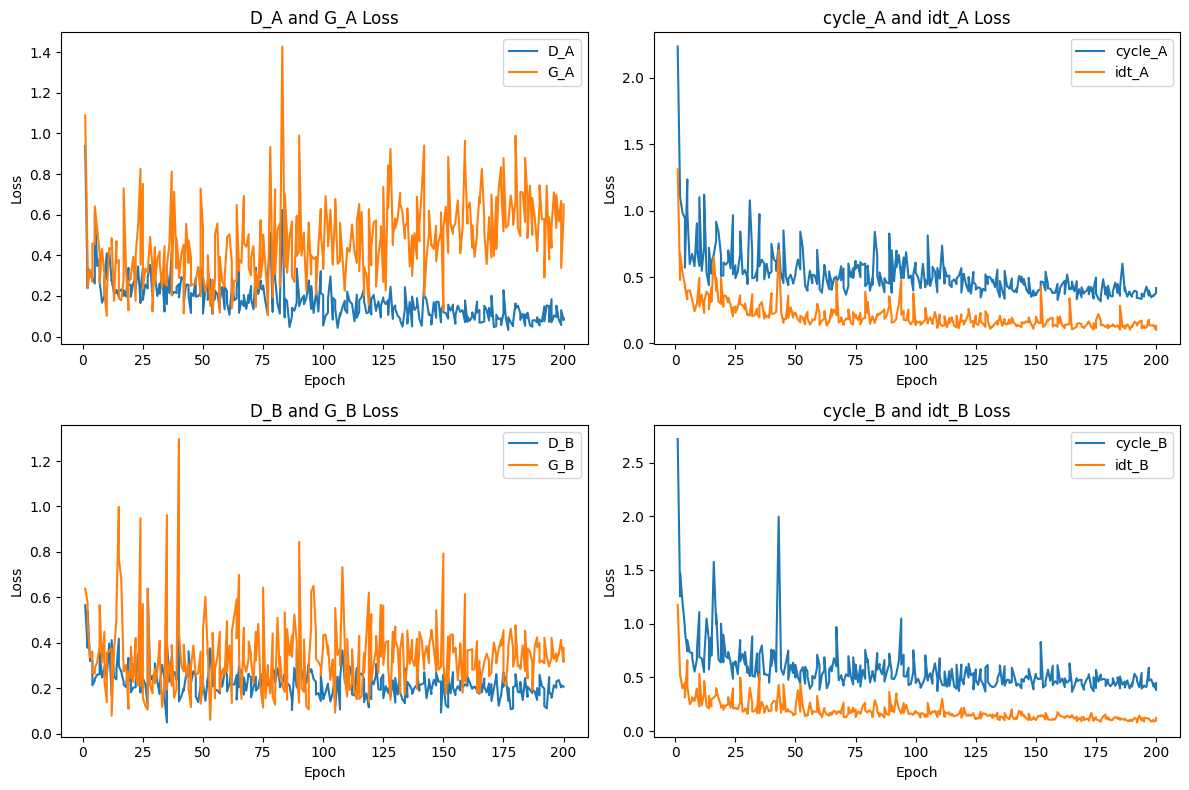

In [41]:
import re
import matplotlib.pyplot as plt

def parse_logs(log_file_path):
    epoch_loss = {
        'epoch': [],
        'D_A': [],
        'G_A': [],
        'cycle_A': [],
        'idt_A': [],
        'D_B': [],
        'G_B': [],
        'cycle_B': [],
        'idt_B': []
    }
    
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            match = re.search(r'\(epoch: (\d+),.* D_A: ([\d.]+) G_A: ([\d.]+) cycle_A: ([\d.]+) idt_A: ([\d.]+) D_B: ([\d.]+) G_B: ([\d.]+) cycle_B: ([\d.]+) idt_B: ([\d.]+)', line)
            if match:
                epoch_loss['epoch'].append(int(match.group(1)))
                epoch_loss['D_A'].append(float(match.group(2)))
                epoch_loss['G_A'].append(float(match.group(3)))
                epoch_loss['cycle_A'].append(float(match.group(4)))
                epoch_loss['idt_A'].append(float(match.group(5)))
                epoch_loss['D_B'].append(float(match.group(6)))
                epoch_loss['G_B'].append(float(match.group(7)))
                epoch_loss['cycle_B'].append(float(match.group(8)))
                epoch_loss['idt_B'].append(float(match.group(9)))
                
    return epoch_loss

def plot_losses(epoch_loss):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(epoch_loss['epoch'], epoch_loss['D_A'], label='D_A')
    plt.plot(epoch_loss['epoch'], epoch_loss['G_A'], label='G_A')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('D_A and G_A Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epoch_loss['epoch'], epoch_loss['cycle_A'], label='cycle_A')
    plt.plot(epoch_loss['epoch'], epoch_loss['idt_A'], label='idt_A')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('cycle_A and idt_A Loss')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(epoch_loss['epoch'], epoch_loss['D_B'], label='D_B')
    plt.plot(epoch_loss['epoch'], epoch_loss['G_B'], label='G_B')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('D_B and G_B Loss')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epoch_loss['epoch'], epoch_loss['cycle_B'], label='cycle_B')
    plt.plot(epoch_loss['epoch'], epoch_loss['idt_B'], label='idt_B')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('cycle_B and idt_B Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

log_file_path = './losses.txt'  # Replace with your actual log file path
epoch_loss = parse_logs(log_file_path)
plot_losses(epoch_loss)


In [1]:
!python test.py --dataroot ../CycleGAN-TensorFlow/CycData/256resized/ --name PAStoIHC --model cycle_gan --phase test


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../CycleGAN-TensorFlow/CycData/256resized/	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                

In [18]:
import os
import shutil
from pathlib import Path

def copy_fake_B_images(src_dir, dst_dir):
    # Create the destination directory if it does not exist
    os.makedirs(dst_dir, exist_ok=True)

    # Iterate over all files in the source directory
    for file_path in Path(src_dir).rglob('*_fake_B.png'):
        file_name = file_path.name
        shutil.copy(file_path, os.path.join(dst_dir, file_name))

if __name__ == "__main__":
    src_dir = './results/PAStoIHC/test_latest/images'
    dst_dir = '../Images/fake_B_images'
    copy_fake_B_images(src_dir, dst_dir)


In [49]:
from PIL import Image
import os
from pathlib import Path

def resize_images(directory, size=(256, 256)):
    # Iterate over all image files in the directory
    for file_path in Path(directory).rglob('*.png'):
        with Image.open(file_path) as img:
            # Resize the image
            resized_img = img.resize(size)
            # Save the resized image, replacing the original image
            resized_img.save(file_path)

if __name__ == "__main__":
    directory = '../Images/masks'  # Replace with your directory path
    resize_images(directory)


In [20]:
import os
import shutil
from pathlib import Path
import re

def move_images(src_dir, dest_dir, min_number=60):
    # Create the destination directory if it doesn't exist
    os.makedirs(dest_dir, exist_ok=True)

    # Define a regex pattern to match image filenames with numbers
    pattern = re.compile(r'mask(\d+)\.png')

    # Iterate over all files in the source directory
    for file_path in Path(src_dir).rglob('*.png'):
        file_name = file_path.name
        match = pattern.match(file_name)
        if match:
            number = int(match.group(1))
            if number >= min_number:
                shutil.move(file_path, os.path.join(dest_dir, file_name))

if __name__ == "__main__":
    src_dir = '../Images/masks'  # Replace with your source directory path
    dest_dir = '../Images/val/masks'  # Replace with your destination directory path
    move_images(src_dir, dest_dir)


In [9]:
!python testB2A.py --dataroot ./256resized --name PAStoIHC --model cycle_gan --phase test --no_dropout


Traceback (most recent call last):
  File "/home/juwumukiza/.local/lib/python3.10/site-packages/torch/__init__.py", line 168, in _load_global_deps
    ctypes.CDLL(lib_path, mode=ctypes.RTLD_GLOBAL)
  File "/apps/jupyter/6.5.4/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: libcurand.so.10: cannot open shared object file: No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/juwumukiza/ImageProcess/pytorch-CycleGAN-and-pix2pix/testB2A.py", line 2, in <module>
    from options.test_options import TestOptions
  File "/home/juwumukiza/ImageProcess/pytorch-CycleGAN-and-pix2pix/options/test_options.py", line 1, in <module>
    from .base_options import BaseOptions
  File "/home/juwumukiza/ImageProcess/pytorch-CycleGAN-and-pix2pix/options/base_options.py", line 3, in <module>
    from util import util
  File "/home/juwumukiza/ImageProcess/p

In [3]:
import os
import shutil

# Define the source directory where your images are currently located
source_dir = "./results/PAStoIHC/test_latest/images"  # Update this path to your image directory

# Define the target directories
target_dirs = ["real_A", "real_B", "fake_A", "fake_B", "rec_A", "rec_B"]

# Create target directories if they don't exist
for dir_name in target_dirs:
    os.makedirs(os.path.join(source_dir, dir_name), exist_ok=True)

# List all files in the source directory
files = os.listdir(source_dir)

# Move files to corresponding directories
for file_name in files:
    file_path = os.path.join(source_dir, file_name)
    if os.path.isfile(file_path):  # Ensure we only process files
        if "real_A" in file_name:
            shutil.move(file_path, os.path.join(source_dir, "real_A", file_name))
        elif "real_B" in file_name:
            shutil.move(file_path, os.path.join(source_dir, "real_B", file_name))
        elif "fake_A" in file_name:
            shutil.move(file_path, os.path.join(source_dir, "fake_A", file_name))
        elif "fake_B" in file_name:
            shutil.move(file_path, os.path.join(source_dir, "fake_B", file_name))
        elif "rec_A" in file_name:
            shutil.move(file_path, os.path.join(source_dir, "rec_A", file_name))
        elif "rec_B" in file_name:
            shutil.move(file_path, os.path.join(source_dir, "rec_B", file_name))

print("Files sorted successfully.")


Files sorted successfully.


In [4]:
import os
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim

def calculate_iou(y_true, y_pred, threshold=0.5):
    y_pred_thresholded = y_pred > threshold
    y_true_thresholded = y_true > threshold
    intersection = np.logical_and(y_true_thresholded, y_pred_thresholded)
    union = np.logical_or(y_true_thresholded, y_pred_thresholded)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_accuracy(y_true, y_pred, threshold=0.5):
    y_pred_thresholded = y_pred > threshold
    y_true_thresholded = y_true > threshold
    correct = np.sum(y_true_thresholded == y_pred_thresholded)
    total = y_true.size
    accuracy = correct / total
    return accuracy

def load_images_from_folder(folder):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

def main():
    real_A_dir = "./results/PAStoIHC/test_latest/images/real_A"
    rec_A_dir = "./results/PAStoIHC/test_latest/images/rec_A"
    
    real_A_images = load_images_from_folder(real_A_dir)
    rec_A_images = load_images_from_folder(rec_A_dir)
    
    assert len(real_A_images) == len(rec_A_images), "Mismatch in the number of images between real_A and rec_A"

    ious = []
    accuracies = []
    ssims = []

    for real_A, rec_A in zip(real_A_images, rec_A_images):
        iou = calculate_iou(real_A, rec_A)
        accuracy = calculate_accuracy(real_A, rec_A)
        ssim_index = ssim(real_A, rec_A)

        ious.append(iou)
        accuracies.append(accuracy)
        ssims.append(ssim_index)

    print(f"Average IoU: {np.mean(ious)}")
    print(f"Average Accuracy: {np.mean(accuracies)}")
    print(f"Average SSIM: {np.mean(ssims)}")

if __name__ == "__main__":
    main()


Average IoU: 1.0
Average Accuracy: 1.0
Average SSIM: 0.9251783073936088


In [9]:
!python addTraining.py --dataroot ../CycleGAN-TensorFlow/CycData/256resized --name PAStoIHC --model cycle_gan 


----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ../CycleGAN-TensorFlow/CycData/256resized	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
   

In [18]:
!python evaluation.py --dataroot ../CycleGAN-TensorFlow/CycData/256resized --name PAStoIHC --model cycle_gan


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../CycleGAN-TensorFlow/CycData/256resized	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                 

In [ ]:
import os
import ctypes

# Update LD_LIBRARY_PATH
os.environ['LD_LIBRARY_PATH'] = '/cmsuf/t2/operations/.conda/envs/weaver/lib:' + os.environ.get('LD_LIBRARY_PATH', '')

# Load necessary libraries
ctypes.CDLL('/cmsuf/t2/operations/.conda/envs/weaver/lib/libcufft.so.10', mode=ctypes.RTLD_GLOBAL)
ctypes.CDLL('/cmsuf/t2/operations/.conda/envs/weaver/lib/libcurand.so.10', mode=ctypes.RTLD_GLOBAL)
ctypes.CDLL('/cmsuf/t2/operations/.conda/envs/weaver/lib/libcupti.so.11.4', mode=ctypes.RTLD_GLOBAL)

import torch

# Verify CUDA availability
print("CUDA is available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("CUDA device name:", torch.cuda.get_device_name(0))
